In [2]:
# load in our packages
# Import cell

import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

import scipy
from scipy.stats import pearsonr, skew, kurtosis
from scipy.spatial import distance
from scipy.interpolate import CubicSpline
# from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# plt.style.use('../../modules/files/plot_style.mplstyle')

import warnings
warnings.filterwarnings('ignore')

1. Get the slope features from the cycle data exactly as in the paper
2. Import all cycle data files(Use baraths template of importing) and plot the 87 batteries discharge vs. cycle index graphs and create a column of the lifecycle data.  


In [71]:
def VQ_extract(df_temp, cycle_index):
  df_temp = df_temp[df_temp['Cycle_Index']==cycle_index]
  df_temp= df_temp[df_temp['Current']<0]
  voltage= df_temp['Voltage'].values
  discharge= df_temp['Discharge_Capacity'].values
  return voltage, discharge
  
def get_timeseries_data(timeseries_path):
  # curr_dir = os.getcwd()
  # data_dir = os.path.join(curr_dir,'data/SNL/SNL LFP')
  # filename ='SNL_18650_LFP_15C_0-100_0.5-1C_a_timeseries.csv'
  #timeseries_path = os.path.join(path, timeseries_name)

  df=pd.read_csv(timeseries_path)
  col_names = {'Test_Time (s)' : 'Test_Time',
              'Current (A)' : 'Current',
              'Voltage (V)' : 'Voltage',
              'Charge_Capacity (Ah)': 'Charge_Capacity',
              'Discharge_Capacity (Ah)': 'Discharge_Capacity',
              'Charge_Energy (Wh)': 'Charge_Energy',
              'Discharge_Energy (Wh)': 'Discharge_Energy',
              'Environment_Temperature (C)': 'Environment_Temperature',
              'Cell_Temperature (C)': 'Cell_Temperature'}

  df = df.rename(columns=col_names)

  voltage_10, discharge_10 = VQ_extract(df, 10)
  voltage_100, discharge_100 = VQ_extract(df, 100)

  fit_10= CubicSpline(np.flip(voltage_10,0), np.flip(discharge_10,0))
  fit_100= CubicSpline(np.flip(voltage_100,0), np.flip(discharge_100,0))
  voltage = np.linspace(2, 3.2, num=100)

  del_discharge= np.subtract(fit_10(voltage), fit_100(voltage))
  del_discharge= np.absolute(del_discharge)
  mean = np.absolute(np.log(np.average(del_discharge)))
  minimum = np.absolute(np.log(np.amin(del_discharge)))
  variance = np.absolute(np.log(np.var(del_discharge)))
  skewness = np.absolute(np.log(skew(del_discharge)))
  kurt = np.absolute(np.log(kurtosis(del_discharge)))
  return mean, minimum, variance, skewness, kurt;

In [4]:
path = "../data/SNL"
#Loading main dataframe
cell_list_path = os.path.join(path, 'ba_cell_list_v2.xlsx')
# print(df_main.head())
df_main = pd.read_excel(cell_list_path)

tags= df_main['cell ID'].values
tags = [s.replace('/', '-') for s in tags]
 

In [5]:
cycle_data_name_array=[]
cycle_data_path_array=[]
for filename in tags:
  cycle_data_name = filename + '_cycle_data.csv'
  cycle_data_name_array.append(cycle_data_name) #Storing the cycledata names in an array
  timeseries_name = filename + '_timeseries.csv'
  chemistry_name = 'SNL '+ filename[10:13]
  data_dir = os.path.join(path, chemistry_name)
  cycle_data_path = os.path.join(data_dir, cycle_data_name)
  cycle_data_path_array.append(cycle_data_path) #Storing the path in an array
  timeseries_path = os.path.join(data_dir, timeseries_name)
# test array length
print(len(cycle_data_path_array))
 

79


['Cycle_Index', 'Start_Time', 'End_Time', 'Test_Time (s)', 'Min_Current (A)', 'Max_Current (A)', 'Min_Voltage (V)', 'Max_Voltage (V)', 'Charge_Capacity (Ah)', 'Discharge_Capacity (Ah)', 'Charge_Energy (Wh)', 'Discharge_Energy (Wh)']


Text(0.5, 1.0, 'Discharge vs. Cycle')

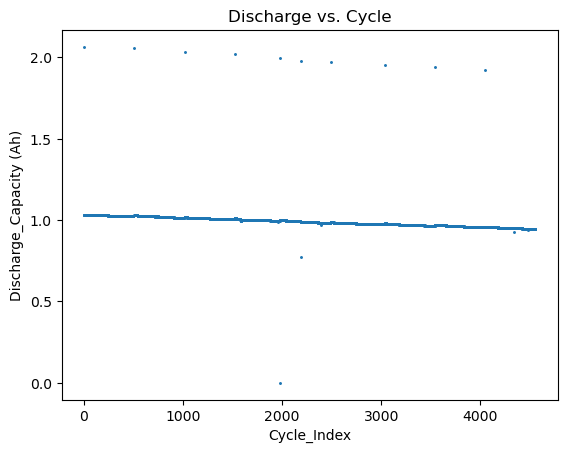

In [7]:
df_cycle_data = pd.read_csv(cycle_data_path_array[0])
columns_temp = list(df_cycle_data)
print(columns_temp)
df_temp = df_cycle_data[(df_cycle_data['Min_Current (A)'] + df_cycle_data['Max_Current (A)']) != 0]
df_temp = df_cycle_data[df_cycle_data['Min_Current (A)'] != -df_cycle_data['Max_Current (A)']]
# plot the two columns as a scatter plot
# for i in range(len(df_cycle_data)):
# plt.scatter(df_cycle_data['Cycle_Index'], df_cycle_data['Discharge_Capacity (Ah)'], marker=".", s=5)
plt.scatter(df_temp['Cycle_Index'], df_temp['Discharge_Capacity (Ah)'], marker=".", s=5)
# add axis labels and a title
plt.xlabel('Cycle_Index')
plt.ylabel('Discharge_Capacity (Ah)')
plt.title('Discharge vs. Cycle')

  # show the plotplt.show()

['Cycle_Index', 'Start_Time', 'End_Time', 'Test_Time (s)', 'Min_Current (A)', 'Max_Current (A)', 'Min_Voltage (V)', 'Max_Voltage (V)', 'Charge_Capacity (Ah)', 'Discharge_Capacity (Ah)', 'Charge_Energy (Wh)', 'Discharge_Energy (Wh)']


Text(0.5, 1.0, 'Discharge vs. Cycle')

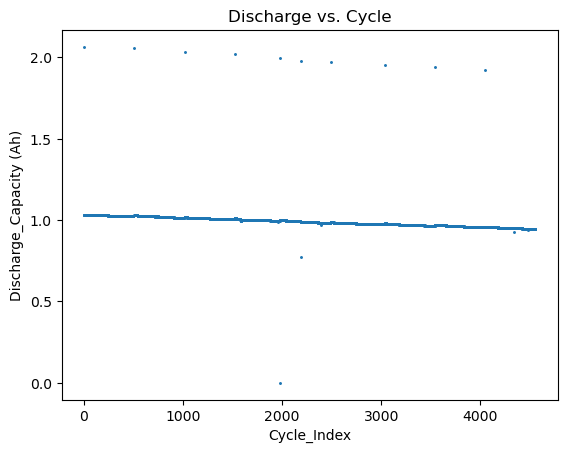

In [8]:
df_cycle_data = pd.read_csv(cycle_data_path_array[0])
columns_temp = list(df_cycle_data)
print(columns_temp)
df_temp = df_cycle_data[(df_cycle_data['Min_Current (A)'] + df_cycle_data['Max_Current (A)']) != 0]
df_temp = df_cycle_data[df_cycle_data['Min_Current (A)'] != -df_cycle_data['Max_Current (A)']]
# plot the two columns as a scatter plot
# for i in range(len(df_cycle_data)):
# plt.scatter(df_cycle_data['Cycle_Index'], df_cycle_data['Discharge_Capacity (Ah)'], marker=".", s=5)
plt.scatter(df_temp['Cycle_Index'], df_temp['Discharge_Capacity (Ah)'], marker=".", s=5)
# add axis labels and a title
plt.xlabel('Cycle_Index')
plt.ylabel('Discharge_Capacity (Ah)')
plt.title('Discharge vs. Cycle')

  # show the plotplt.show()

['Cycle_Index', 'Start_Time', 'End_Time', 'Test_Time (s)', 'Min_Current (A)', 'Max_Current (A)', 'Min_Voltage (V)', 'Max_Voltage (V)', 'Charge_Capacity (Ah)', 'Discharge_Capacity (Ah)', 'Charge_Energy (Wh)', 'Discharge_Energy (Wh)']


Text(0.5, 1.0, 'Discharge vs. Cycle')

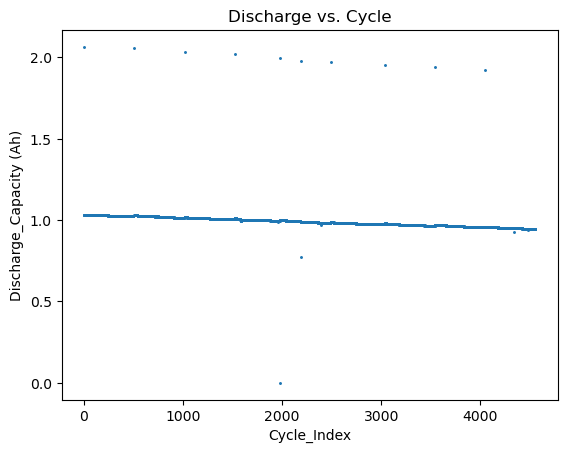

In [9]:
df_cycle_data = pd.read_csv(cycle_data_path_array[0])
columns_temp = list(df_cycle_data)
print(columns_temp)
df_temp = df_cycle_data[(df_cycle_data['Min_Current (A)'] + df_cycle_data['Max_Current (A)']) != 0]
df_temp = df_cycle_data[df_cycle_data['Min_Current (A)'] != -df_cycle_data['Max_Current (A)']]
# plot the two columns as a scatter plot
# for i in range(len(df_cycle_data)):
# plt.scatter(df_cycle_data['Cycle_Index'], df_cycle_data['Discharge_Capacity (Ah)'], marker=".", s=5)
plt.scatter(df_temp['Cycle_Index'], df_temp['Discharge_Capacity (Ah)'], marker=".", s=5)
# add axis labels and a title
plt.xlabel('Cycle_Index')
plt.ylabel('Discharge_Capacity (Ah)')
plt.title('Discharge vs. Cycle')

  # show the plotplt.show()

In [12]:
def remove_outliers(df, columns, z_thresh=1):
    """
    Removes outliers from the specified columns in a pandas dataframe.
    
    Args:
        df (pandas.DataFrame): The input dataframe.
        columns (list): A list of column names to remove outliers from.
        z_thresh (float): The z-score threshold above which a value is considered an outlier. Default is 3.
    
    Returns:
        pandas.DataFrame: A new dataframe with the outliers removed.
    """
    # Create a new dataframe to store the non-outlier values
    new_df = pd.DataFrame(columns=df.columns)
    
    for col in columns:
        # Calculate the z-scores for each value in the column
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        
        # Create a boolean mask for values that are not outliers
        mask = z_scores < z_thresh
        
        # Add the non-outlier values to the new dataframe
        new_df = new_df.append(df[mask])
    
    return new_df



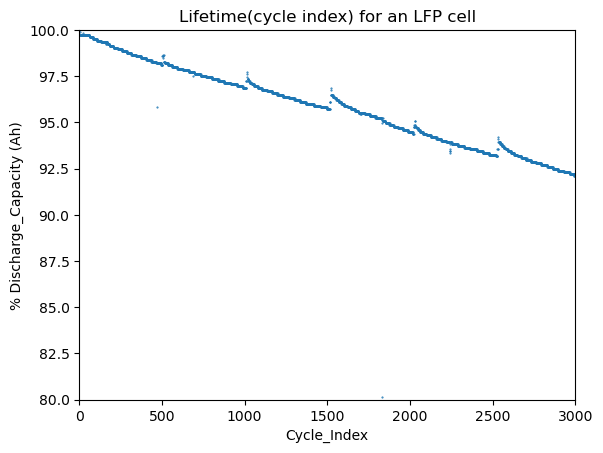

In [19]:
df_cycle_data = pd.read_csv(cycle_data_path_array[8])
new_df = remove_outliers(df_cycle_data, ['Discharge_Capacity (Ah)'], z_thresh=3)

xtoplot = np.array(new_df['Cycle_Index'])
temp = new_df['Discharge_Capacity (Ah)']
ytoplot = np.array([100*p/np.max(temp) for p in temp])
n_avg = 1
if len(xtoplot)%n_avg != 0:
  N = len(xtoplot)%n_avg
  new_x_arr = xtoplot[:-N]
  new_y_arr = ytoplot[:-N]
else:
  new_x_arr = xtoplot
  new_y_arr = ytoplot

x_avg = np.average(new_x_arr.reshape(-1, n_avg), axis=1)
y_avg = np.average(new_y_arr.reshape(-1, n_avg), axis=1)
plt.scatter(x_avg, y_avg, marker=".", s = 1)
plt.xlabel('Cycle_Index')
plt.ylabel('% Discharge_Capacity (Ah)')
plt.title('Lifetime(cycle index) for an LFP cell')
plt.xlim([0, 3000])
plt.ylim([80, 100])
figure_path = '../figures'
plt.savefig(figure_path + '/LFP_Qvscy.png')

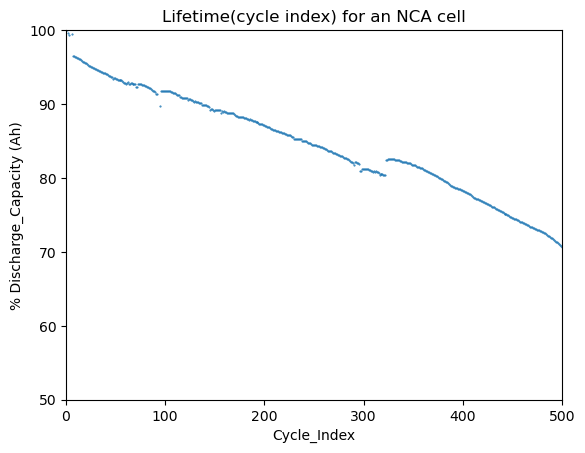

In [20]:
df_cycle_data = pd.read_csv(cycle_data_path_array[31])
new_df = remove_outliers(df_cycle_data, ['Discharge_Capacity (Ah)'], z_thresh=3)

xtoplot = np.array(new_df['Cycle_Index'])
temp = new_df['Discharge_Capacity (Ah)']
ytoplot = np.array([100*p/np.max(temp) for p in temp])
n_avg = 1
if len(xtoplot)%n_avg != 0:
  N = len(xtoplot)%n_avg
  new_x_arr = xtoplot[:-N]
  new_y_arr = ytoplot[:-N]
else:
  new_x_arr = xtoplot
  new_y_arr = ytoplot

x_avg = np.average(new_x_arr.reshape(-1, n_avg), axis=1)
y_avg = np.average(new_y_arr.reshape(-1, n_avg), axis=1)
plt.scatter(x_avg, y_avg, marker=".", s = 1)
plt.xlabel('Cycle_Index')
plt.ylabel('% Discharge_Capacity (Ah)')
plt.title('Lifetime(cycle index) for an NCA cell')
plt.xlim([0, 500])
plt.ylim([50, 100])
figure_path = '../figures'
plt.savefig(figure_path + '/NCA_Qvscy.png')

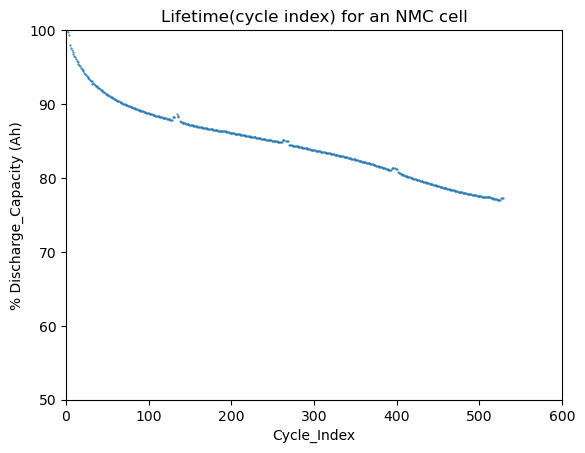

In [21]:
df_cycle_data = pd.read_csv(cycle_data_path_array[60])
new_df = remove_outliers(df_cycle_data, ['Discharge_Capacity (Ah)'], z_thresh=3)

xtoplot = np.array(new_df['Cycle_Index'])
temp = new_df['Discharge_Capacity (Ah)']
ytoplot = np.array([100*p/np.max(temp) for p in temp])
n_avg = 1
if len(xtoplot)%n_avg != 0:
  N = len(xtoplot)%n_avg
  new_x_arr = xtoplot[:-N]
  new_y_arr = ytoplot[:-N]
else:
  new_x_arr = xtoplot
  new_y_arr = ytoplot

x_avg = np.average(new_x_arr.reshape(-1, n_avg), axis=1)
y_avg = np.average(new_y_arr.reshape(-1, n_avg), axis=1)
plt.scatter(x_avg, y_avg, marker=".", s = 1)
plt.xlabel('Cycle_Index')
plt.ylabel('% Discharge_Capacity (Ah)')
plt.title('Lifetime(cycle index) for an NMC cell')
plt.xlim([0, 600])
plt.ylim([50, 100])
figure_path = '../figures'
plt.savefig(figure_path + '/NMC_Qvscy.png')